# Detailed analysis of network 2

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap

/home/surchs/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:1011: UserWarning: Duplicate key in file "/home/surchs/.config/matplotlib/matplotlibrc", line #405
  (fname, cnt))


In [2]:
%matplotlib inline

# Paths

In [3]:
# Paths
scale = 12
subtypes = 3
network_number = 1
net_id = network_number - 1
mtp = 'stability_maps'
tpl = '*_fmri_{:07d}_session_1_run1_stability_maps.nii.gz'
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale012.nii.gz'
data_path = '/data1/abide/Out/Scores/sc{:02d}/time'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_3box_189_sample.csv'
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
out_path = '/data1/subtypes/sc12'

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)
# Grab the corresponding file paths - should be sure that they exist
path_list = [glob.glob(os.path.join(data_path, mtp, tpl.format(r['SUB_ID'])))[0] for i, r in pheno.iterrows()]

In [6]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

# Define some functions and the niak colormap

In [7]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

## Build the subtypes and compute the weights

In [10]:
# Generate the model matrix
factors = ['DX_GROUP', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

In [28]:
# Run over all subtypes and networks
scale = 12
subtypes = 5
n_vox = np.sum(mask)
n_files = len(path_list)
# Let's run the model again for all networks and subtypes

pval_store = np.zeros((scale, subtypes))
weight_store = np.zeros((scale, subtypes, n_files))
sbt_store = np.zeros((scale, subtypes, n_vox))
sbt_store_2 = np.zeros((scale, subtypes, n_vox))
corr_store = np.zeros((n_files, n_files, scale))
link_store = np.zeros((n_files-1,4,scale))
part_store = np.zeros((scale, n_files))

# Just run network 2
net_id = 1
res_list = list()
# Get the scores maps into a voxel by subject array
# Init store
net_stack = np.zeros((n_vox, n_files))
# Iterate files
for index, s_path in enumerate(path_list):
    # Getting data
    f_net = nib.load(s_path).get_data()[mask][..., net_id]
    net_stack[..., index] = f_net

grand_average = np.reshape(np.mean(net_stack, 1), (net_stack.shape[0], 1))
# Save a copy of the non-demeanded subtypes
net_stack_2 = np.copy(net_stack)
# Demean the net stack
net_stack = net_stack - grand_average
# Save the grand average
tmpl = np.zeros_like(mask, dtype=np.float64)
tmpl[mask] = grand_average[:, 0]
gdavg = tmpl

# Build correlation matrix on the network stack
corr_mat = np.corrcoef(net_stack, rowvar=0)
# Compute linkage with Ward's criterion
link_mat = scl.hierarchy.linkage(corr_mat, method='ward')
# Store both
corr_store[..., net_id] = corr_mat
link_store[..., net_id] = link_mat
# Partition the linkage to get a given number of subtypes
part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
part_store[net_id, :] = part_sub

# Init store - Build subtypes
sub_stack = np.zeros((n_vox, subtypes))
for s_id in range(subtypes):
    sbt = np.mean(net_stack[:, part_sub==s_id+1],1)
    sub_stack[:,s_id] = sbt
    sbt_store[net_id, s_id, :] = sbt

# Make the non-demeaned subtypes
for s_id in range(subtypes):
    sbt = np.mean(net_stack_2[:, part_store[net_id, :]==s_id+1],1)
    sbt_store_2[net_id, s_id, :] = sbt

# Init store - Compute the weights
for s_id in range(subtypes):
    type_map = sub_stack[:, s_id]
    weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, net_stack[:,x])[0,1] for x in range(n_files)])

# Loop through the subtypes
for s_id in range(subtypes):
    model = sm.OLS(weight_store[net_id, s_id, :], glm_pheno)
    results = model.fit()
    # Save the p-values
    pval_store[net_id, s_id] = results.pvalues['DX_GROUP']
    res_list.append(results)

In [13]:
# Find the subjects that are ASD (1) and controls (2)
sub_asd = pheno['DX_GROUP'].values == 1
sub_tdc = pheno['DX_GROUP'].values == 2

In [29]:
# Turn the grand average into an image
gdavg_img = nib.Nifti1Image(gdavg, affine=m_img.get_affine(), header=m_img.get_header())

In [31]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

In [25]:
pval_store.dtype

dtype('float64')

In [27]:
gdavg.dtype

dtype('float16')

# Network 2

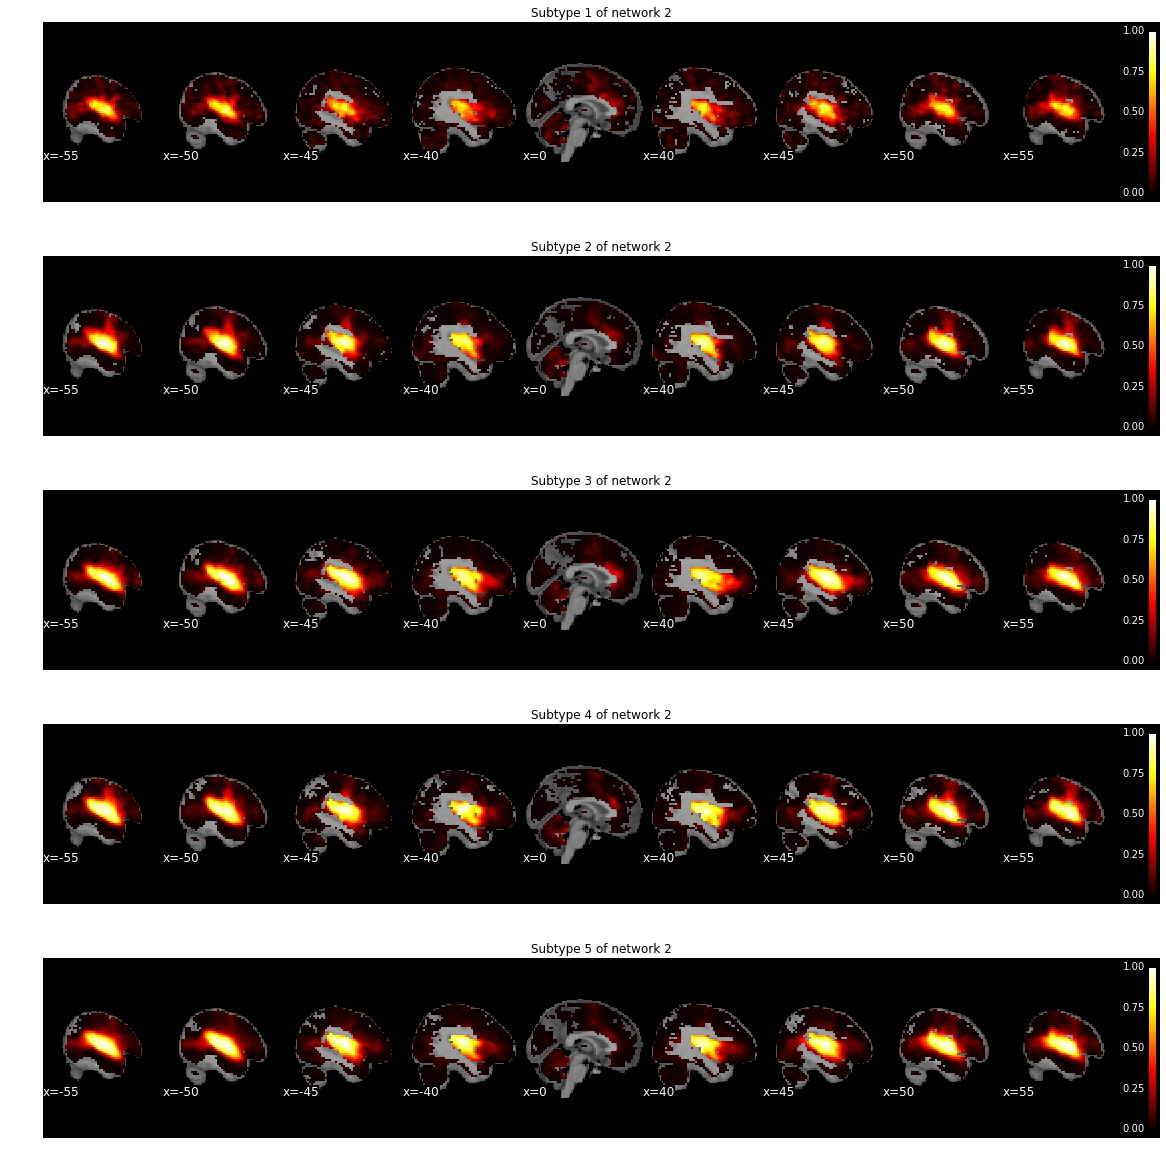

In [48]:
net_id = 1
# First, get an overview of the network
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(5, 1, hspace=0.3)
view_range = np.array([-55,-50,-45,-40,0,40,45,50,55])


for sbt_id in range(5):
    ax = fig.add_subplot(gs[sbt_id,0])
    sbt_dm = sbt_store_2[net_id,sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt_dm
    sbt_dm_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_stat_map(sbt_dm_img, axes=ax, display_mode='x', vmax=1,
                      cut_coords=view_range, black_bg=True)
    ax.set_title('Subtype {} of network 2'.format(sbt_id+1))

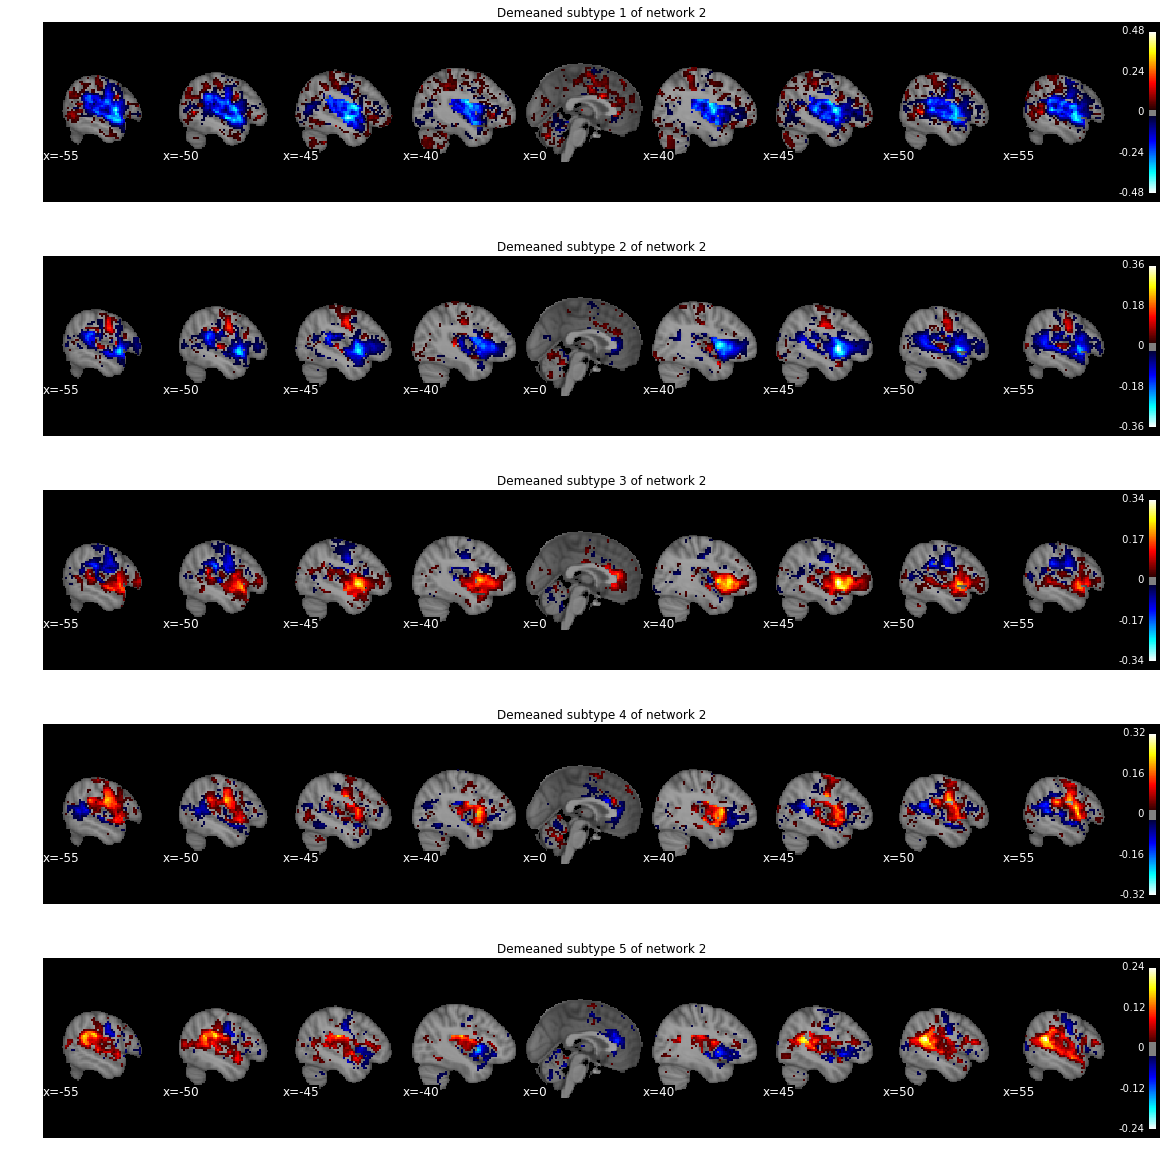

In [45]:
net_id = 1
# First, get an overview of the network
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(5, 1, hspace=0.3)
view_range = np.array([-55,-50,-45,-40,0,40,45,50,55])


for sbt_id in range(5):
    ax = fig.add_subplot(gs[sbt_id,0])
    sbt_dm = sbt_store[net_id,sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt_dm
    sbt_dm_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_stat_map(sbt_dm_img, axes=ax, display_mode='x', threshold=0.02, 
                      cut_coords=view_range, black_bg=True)
    ax.set_title('Demeaned subtype {} of network 2'.format(sbt_id+1))

From this overview of all subtypes of network 2, it is visually apparent that __subtype 3 looks like the opposite of subtype 5__. While subtype 3 did not show any association with diagnosis after FDR correction, it may still be worth exploring.

## Subtype 3

In [52]:
# Look at the results of the GLM for subtype 3
print(res_list[2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     7.369
Date:                Fri, 11 Sep 2015   Prob (F-statistic):           6.74e-11
Time:                        21:20:50   Log-Likelihood:                 115.47
No. Observations:                 189   AIC:                            -204.9
Df Residuals:                     176   BIC:                            -162.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1096      0.055      1.982      

## Subtype 5

In [53]:
# Look at the results of the GLM for subtype 5
print(res_list[4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     5.987
Date:                Fri, 11 Sep 2015   Prob (F-statistic):           1.02e-08
Time:                        21:21:35   Log-Likelihood:                 131.08
No. Observations:                 189   AIC:                            -236.2
Df Residuals:                     176   BIC:                            -194.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2313      0.051      4.542      

## Comparison

[<matplotlib.text.Text at 0x1fa7d990>, <matplotlib.text.Text at 0x1fa90810>]

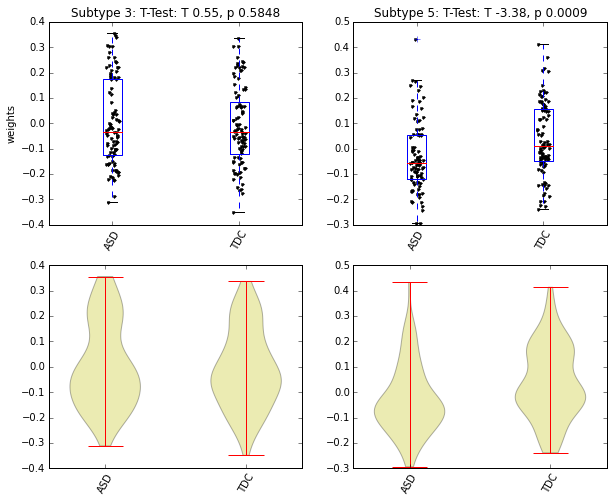

In [65]:
n_asd = np.sum(sub_asd)
n_tdc = np.sum(sub_tdc)

fig = plt.figure(figsize=(10,8))
# Subtype 3 first
sbt_weights = weight_store[1, 2,:]
# Get the weights for the asd and tdc cases
asd_weights = sbt_weights[sub_asd]
tdc_weights = sbt_weights[sub_tdc]
# T-test
[t,p] = st.ttest_ind(asd_weights, tdc_weights)

# Visualize it
ax1 = fig.add_subplot(221)
# Indices
ind_asd = np.ones(n_asd) + (np.random.random(n_asd)*2-1)*0.05
ind_tdc = np.ones(n_tdc) + (np.random.random(n_tdc)*2-1)*0.05 + 1

ax1.plot(ind_asd, asd_weights, 'k.')
ax1.plot(ind_tdc, tdc_weights, 'k.')
ax1.boxplot([asd_weights, tdc_weights])
ax1.set_xticklabels(['ASD', 'TDC'], rotation=60)
ax1.set_ylabel('weights')
ax1.set_title('Subtype 3: T-Test: T {:.2f}, p {:.4f}'.format(t,p))

ax2 = fig.add_subplot(223)
tmp = ax2.violinplot([asd_weights, tdc_weights])
ax2.set_xticks([1,2])
ax2.set_xticklabels(['ASD', 'TDC'], rotation=60)

# Subtype 5 now
sbt_weights = weight_store[1, 4,:]
# Get the weights for the asd and tdc cases
asd_weights = sbt_weights[sub_asd]
tdc_weights = sbt_weights[sub_tdc]
# T-test
[t,p] = st.ttest_ind(asd_weights, tdc_weights)

# Visualize it
ax3 = fig.add_subplot(222)
# Indices
ind_asd = np.ones(n_asd) + (np.random.random(n_asd)*2-1)*0.05
ind_tdc = np.ones(n_tdc) + (np.random.random(n_tdc)*2-1)*0.05 + 1

ax3.plot(ind_asd, asd_weights, 'k.')
ax3.plot(ind_tdc, tdc_weights, 'k.')
ax3.boxplot([asd_weights, tdc_weights])
ax3.set_xticklabels(['ASD', 'TDC'], rotation=60)
ax3.set_title('Subtype 5: T-Test: T {:.2f}, p {:.4f}'.format(t,p))

ax4 = fig.add_subplot(224)
tmp = ax4.violinplot([asd_weights, tdc_weights])
ax4.set_xticks([1,2])
ax4.set_xticklabels(['ASD', 'TDC'], rotation=60)

From the above image and results of the GLM analysis, it is clear that there is not sufficient difference between the subtype3 weights of ASD and TDC to act as a meaningful predictor. With this in mind, there there is a negative T value associated with subtype 3, indicating that the trend goes in an inverse direction, compared to subtype 5. 